<h1><center>ASHRAE - Great Energy Predictor III - Feature Engineering💡</center></h1>

# Libraries 📚

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Read data from interim files

In [2]:
%%time
train_df = pd.read_feather("../data/interim/train.feather")
test_df = pd.read_feather("../data/interim/test.feather")
weather_train_df = pd.read_feather("../data/interim/weather_train.feather")
weather_test_df = pd.read_feather("../data/interim/weather_test.feather")
building_metadata_df = pd.read_feather("../data/interim/building_metadata.feather")
sample_submission_df = pd.read_feather("../data/interim/sample_submission.feather")

CPU times: user 2.07 s, sys: 2.27 s, total: 4.34 s
Wall time: 8 s


### Correct Timestamp

In [3]:
def correct_timestamp_dtype(df):
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [4]:
weather_train_df = correct_timestamp_dtype(weather_train_df)
train_df = correct_timestamp_dtype(train_df)
weather_test_df = correct_timestamp_dtype(weather_test_df)
test_df = correct_timestamp_dtype(test_df)

### Reduce Memory

In [5]:
#%%writefile reduce_mem_df.py
#import pandas as pd
def reduce_mem_df(df):
    df_mem_before = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(df_mem_before))
    
    for col in df.columns:
        if df[col].dtype == 'datetime64' or pd.api.types.is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == "float":
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    df_mem_after = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(df_mem_after))
    print("Decreased by {:.1f}%".format(100 * (df_mem_before - df_mem_after) / df_mem_before))
    
    return df

In [6]:
weather_train_df = reduce_mem_df(weather_train_df)
weather_test_df = reduce_mem_df(weather_test_df)
building_metadata_df = reduce_mem_df(building_metadata_df)
train_df = reduce_mem_df(train_df)
test_df = reduce_mem_df(test_df)

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.93 MB
Decreased by 48.6%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 9.78 MB
Decreased by 48.6%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.4%
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


### Adjust outliers

In [8]:
def adjust_outliers_weather(weather_df):
    cols=['air_temperature','dew_temperature','precip_depth_1_hr','cloud_coverage','wind_speed','wind_direction','sea_level_pressure']
    for col in cols:
        Q1 = weather_df[col].quantile(0.25)
        Q3 = weather_df[col].quantile(0.75)
        IQR = Q3 - Q1
        weather_df[weather_df[col] < Q1 - 2.5 * IQR].col = Q1 - 2.5 * IQR
        weather_df[weather_df[col] > Q1 + 2.5 * IQR].col = Q1 + 2.5 * IQR
    return weather_df

In [9]:
weather_train_df = adjust_outliers_weather(weather_train_df)
weather_test_df = adjust_outliers_weather(weather_test_df)

### Fill missing weather data

In [10]:
def fill_missing_weather(weather_df):
    weather_df = weather_df.set_index(['site_id','timestamp']).unstack(0)
    weather_df = weather_df.resample('H').interpolate(limit_direction='both')
    weather_df = weather_df.stack()
    weather_df.fillna(weather_df.groupby('timestamp').mean(),inplace=True)
    weather_df.reset_index(inplace=True)
    return weather_df

In [11]:
weather_train_df = fill_missing_weather(weather_train_df)
weather_test_df = fill_missing_weather(weather_test_df)

In [12]:
weather_train_df.isna().sum()

timestamp             0
site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [13]:
def fill_missing_building_metadata(df):
    df['year_built'] = df['year_built'].fillna(building_metadata_df['year_built'].min())
    df['floor_count'] = df['floor_count'].fillna(0)
    return df

In [14]:
building_metadata_df = fill_missing_building_metadata(building_metadata_df)

In [15]:
building_metadata_df.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [16]:
def fill_missing_meter_reading_df(df):
    df = df.set_index('timestamp')
    df = df.pivot(columns=['building_id','meter'],values='meter_reading')
    df = df.resample('H').interpolate(limit_direction='both')
    df = df.melt(ignore_index=False)
    df['meter'] = df['meter'].astype("category")
    return df

In [17]:
train_df = fill_missing_meter_reading_df(train_df)

In [18]:
train_df = reduce_mem_df(train_df)

Memory usage of dataframe is 418.69 MB
Memory usage after optimization is: 299.06 MB
Decreased by 28.6%


In [19]:
train_df.isna().sum()

building_id    0
meter          0
value          0
dtype: int64

## Adding date features

#### Find out which lags to add as features

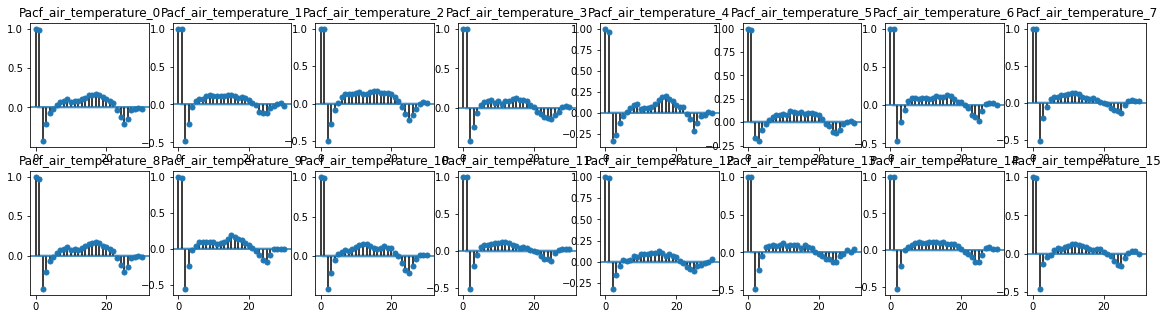

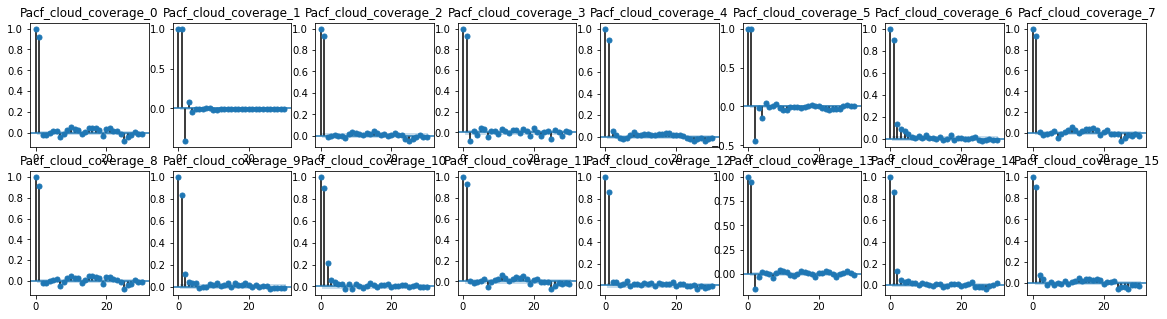

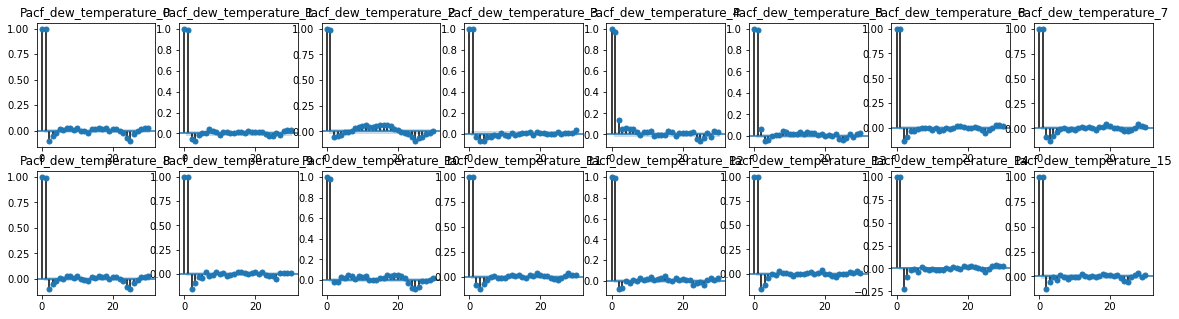

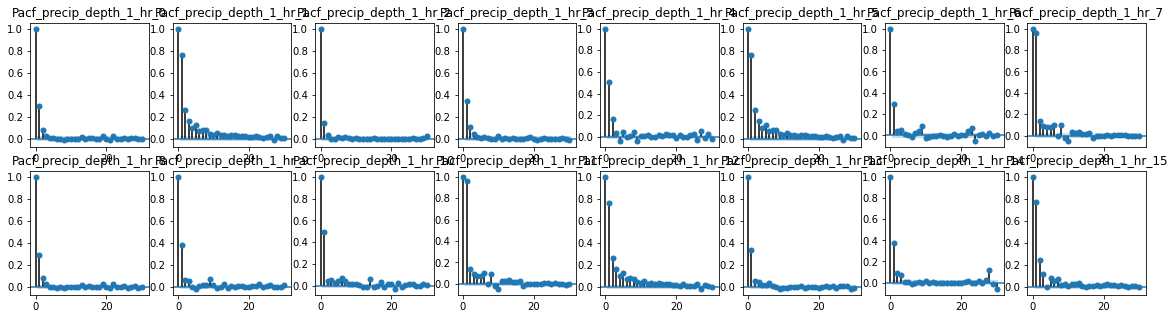

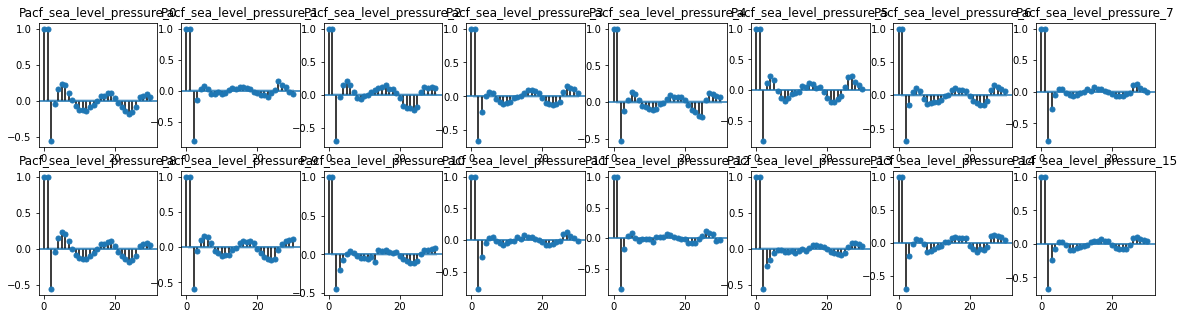

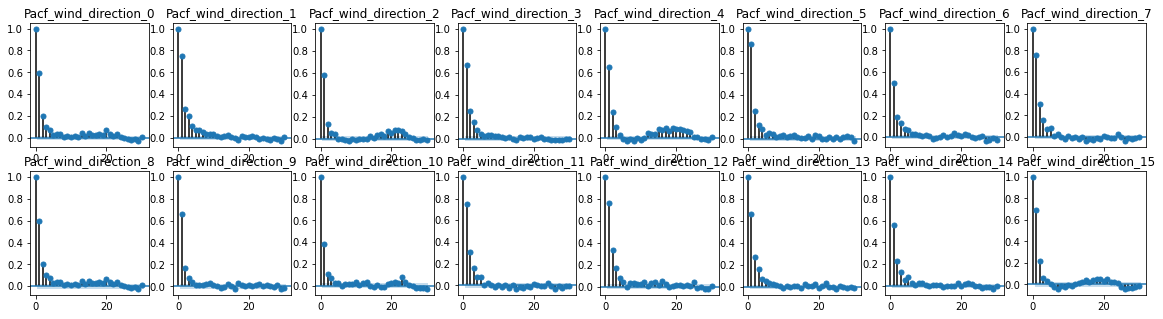

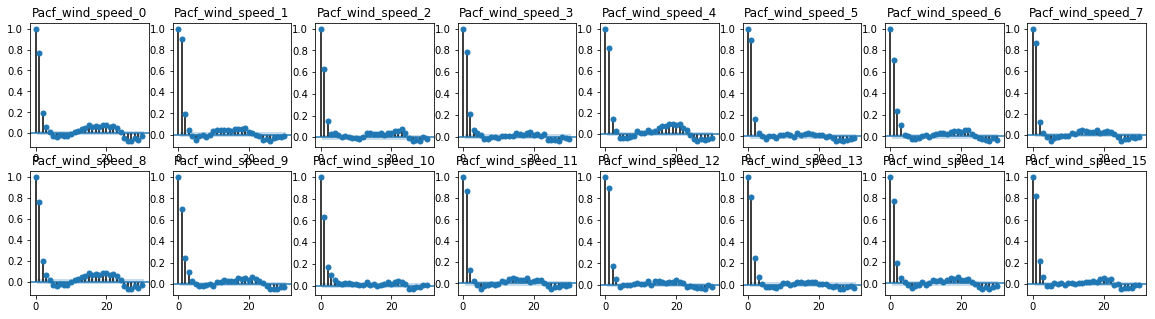

In [22]:
cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weather_train_df.set_index('timestamp')
for col in cols:
    fig, axes = plt.subplots(2,8,figsize=(20,5))
    for sid in weather_train_df.site_id.unique():
        _dfw = weather_train_df[weather_train_df.site_id==sid][col]
        pacf_air_temp = sm.graphics.tsa.plot_pacf(_dfw,lags=30,ax=axes.ravel()[sid],title = 'Pacf_'+col+'_'+str(sid))
weather_train_df.reset_index(inplace=True)

Column              --> lags
'air_temperature'   --> 1,2
'cloud_coverage'    --> 1
'dew_temperature'   --> 1
'precip_depth_1_hr' --> 1
'sea_level_pressure'--> 1,2
'wind_direction'    --> 1,2
'wind_speed'        --> 1,2

In [20]:
def add_lag_features(df,col,lag=1):
    df = df.set_index(['site_id','timestamp'])
    df[f'{col}_shift{lag}'] = df.groupby(level=0).shift(1)[col]
    df[f'{col}_shift{lag}'].fillna(method='bfill',inplace=True)
    return df.reset_index()

In [21]:
def add_roll_mean_features(df,col,window):
    _df = df.set_index(['timestamp']).groupby('site_id').rolling(window).mean()[col]
    _df.fillna(method='bfill',inplace=True)
    return df.set_index(['site_id','timestamp']).join(_df,rsuffix=f'_rollmean_{window}').reset_index()

In [23]:
cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
for col in cols:
    weather_train_df = add_roll_mean_features(weather_train_df,col,6)
    weather_test_df = add_roll_mean_features(weather_test_df,col,6)

In [24]:
for col in cols:
    weather_train_df = add_lag_features(weather_train_df,col,1)
    weather_test_df = add_lag_features(weather_test_df,col,1)
cols2 = ['air_temperature','sea_level_pressure', 'wind_direction', 'wind_speed']    
for col in cols2:
    weather_train_df = add_lag_features(weather_train_df,col,2)
    weather_test_df = add_lag_features(weather_test_df,col,2)

In [186]:
#weather_test_df.drop(weather_test_df.filter(regex='rollmean_6').columns,axis=1,inplace=True)

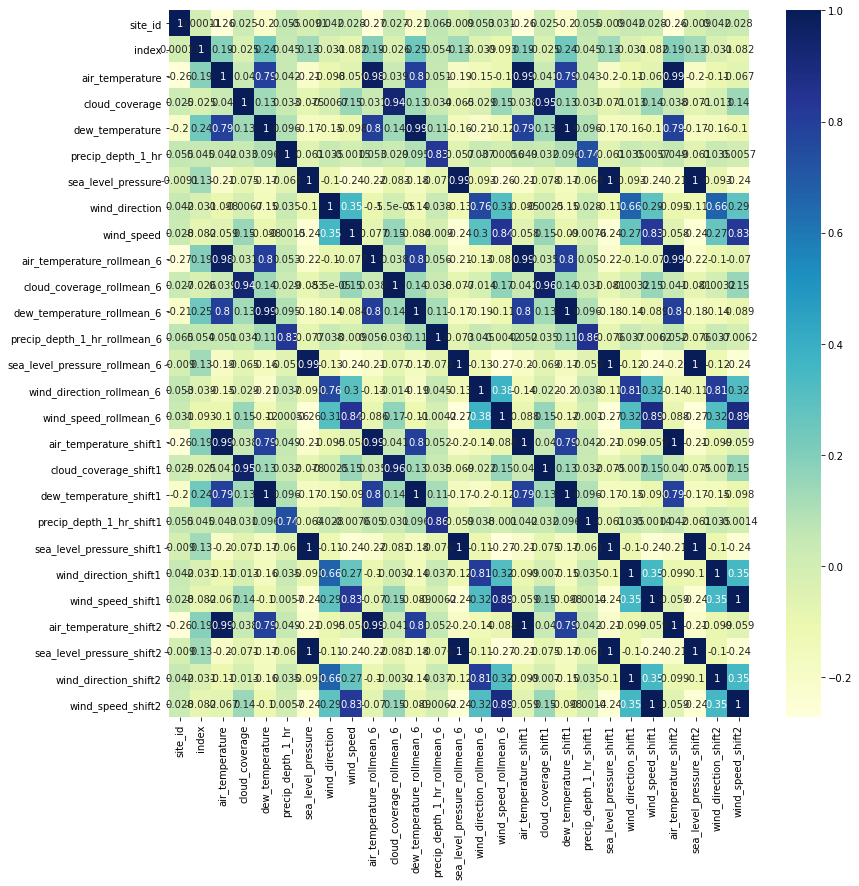

In [29]:
plt.figure(figsize=(13,13))
sns.heatmap(weather_train_df.corr(),annot=True,cmap="YlGnBu",)

In [30]:
#def per_change(series):
#    previous_values = series[:-1]
#    last_value = series[-1]
#    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values) 
#    return percent_change

In [31]:
def add_date_features(df):
    df['time'] = df['timestamp'].dt.time
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['day_of_week'] = df['timestamp'].dt.dayofweek   
    df['week'] = df['timestamp'].dt.isocalendar().week    
    return df

In [32]:
weather_train_df = add_date_features(weather_train_df)
weather_test_df = add_date_features(weather_test_df)

## Renaming columns

In [28]:
train_df = train_df.rename(columns={"meter": "meter_type", "value": "meter_reading"})
test_df = test_df.rename(columns={"meter": "meter_type", "value": "meter_reading"})

## Converting meter reading to Log Scale

In [33]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

### Aggregating meter values by building_id and assigning to train_df columns

In [57]:
def aggregate_by_building_id(train_df):
    df_group = train_df.groupby(['building_id','meter_type'])['meter_reading_log1p']
    train_df['meter_build_mean'] = df_group.transform('mean')
    train_df['meter_build_median'] = df_group.transform('median')
    train_df['meter_build_min'] = df_group.transform('min')
    train_df['meter_build_max'] = df_group.transform('max')
    train_df['meter_build_std'] = df_group.transform('std')  
    return train_df

### Aggregating meter rolling mean values to train_df columns

In [44]:
#_train_df = train_df.groupby(['building_id','meter_type']).rolling(6).mean()['meter_reading_log1p']
#_train_df.fillna(method='bfill',inplace=True)
#train_df = train_df.reset_index().set_index(['building_id','meter_type','timestamp'])\
        .join(_train_df,rsuffix=f'_rollmean_6').reset_index()

In [58]:
train_df = aggregate_by_building_id(train_df.set_index('timestamp'))

In [60]:
def aggregate_by_building_id_test(train_df,test_df):
    df_group = train_df.groupby(['building_id','meter_type'])['meter_reading_log1p']
    test_df['meter_build_mean'] = pd.merge(test_df, df_group.mean().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_median'] = pd.merge(test_df, df_group.median().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_min'] = pd.merge(test_df, df_group.min().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_max'] = pd.merge(test_df, df_group.max().reset_index(), on=['building_id','meter_type'], how='left')\
                                   ['meter_reading_log1p']
    test_df['meter_build_std'] = pd.merge(test_df, df_group.std().reset_index(), on=['building_id','meter_type'], how='left')\
                                  ['meter_reading_log1p']  
    return test_df

In [61]:
test_df = aggregate_by_building_id_test(train_df,test_df)

In [64]:
test_df

,row_id,building_id,meter_type,timestamp,meter_build_mean,meter_build_median,meter_build_min,meter_build_max,meter_build_std
0,0,0,0,2017-01-01 00:00:00,2.606922,4.036297,0.000000,4.885139,2.067543
1,1,1,0,2017-01-01 00:00:00,2.229527,3.362045,0.000000,4.327313,1.725568
2,2,2,0,2017-01-01 00:00:00,1.180073,1.324631,0.000000,3.040984,1.036532
3,3,3,0,2017-01-01 00:00:00,2.875912,4.538250,0.000000,5.619076,2.291754
4,4,4,0,2017-01-01 00:00:00,3.788577,6.054730,0.000000,6.960172,2.981101
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,2.043693,2.054124,0.000000,3.606177,0.441421
41697596,41697596,1445,0,2018-05-09 07:00:00,1.756825,1.800058,1.223776,2.472328,0.233087
41697597,41697597,1446,0,2018-05-09 07:00:00,1.079105,0.753772,0.000000,2.791165,1.056654
41697598,41697598,1447,0,2018-05-09 07:00:00,5.236624,5.256844,4.895411,5.560778,0.120294


In [65]:
train_df.drop('meter_reading_log1p_rollmean_6',axis=1)

,building_id,meter_type,meter_reading,meter_reading_log1p,meter_build_mean,meter_build_median,meter_build_min,meter_build_max,meter_build_std
timestamp,,,,,,,,,
2016-01-01 00:00:00,0,0,0.000000,0.000000,2.606922,4.036297,0.000000,4.885139,2.067543
2016-01-01 01:00:00,0,0,0.000000,0.000000,2.606922,4.036297,0.000000,4.885139,2.067543
2016-01-01 02:00:00,0,0,0.000000,0.000000,2.606922,4.036297,0.000000,4.885139,2.067543
2016-01-01 03:00:00,0,0,0.000000,0.000000,2.606922,4.036297,0.000000,4.885139,2.067543
2016-01-01 04:00:00,0,0,0.000000,0.000000,2.606922,4.036297,0.000000,4.885139,2.067543
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,403,0,43.660000,3.799078,3.820448,3.814410,3.762827,4.471982,0.049116
2016-12-31 20:00:00,403,0,43.639999,3.798630,3.820448,3.814410,3.762827,4.471982,0.049116
2016-12-31 21:00:00,403,0,43.889999,3.804215,3.820448,3.814410,3.762827,4.471982,0.049116


In [66]:
dir = "../data/interim/post_featureEng/"
train_df.to_pickle(dir + "train_df.pickle")
test_df.to_pickle(dir + "test_df.pickle")
weather_train_df.to_pickle(dir + "weather_train_df.pickle")
weather_test_df.to_pickle(dir + "weather_test_df.pickle")
building_metadata_df.to_pickle(dir + "building_metadata_df.pickle")

In [72]:
test_df.set_index('timestamp').describe()

,row_id,building_id,meter_type,meter_build_mean,meter_build_median,meter_build_min,meter_build_max,meter_build_std
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01,3.287488e+00,3.320358e+00,9.768010e-01,4.728386e+00,9.935183e-01
std,1.203706e+07,4.297680e+02,9.278067e-01,1.821684e+00,2.038912e+00,1.501860e+00,2.194023e+00,8.124672e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,3.740248e-06,0.000000e+00,0.000000e+00,3.999200e-04,2.133308e-06
25%,1.042440e+07,4.047500e+02,0.000000e+00,2.939531e+00,3.062611e+00,0.000000e+00,4.655031e+00,3.695103e-01
50%,2.084880e+07,9.000000e+02,0.000000e+00,4.097641e+00,4.355973e+00,0.000000e+00,5.771789e+00,7.175361e-01
75%,3.127320e+07,1.194250e+03,1.000000e+00,5.248024e+00,5.450384e+00,1.905085e+00,7.299723e+00,1.433680e+00
max,4.169760e+07,1.448000e+03,3.000000e+00,1.084105e+01,1.059744e+01,7.650526e+00,1.690221e+01,4.642347e+00


In [73]:
train_df.describe()

,building_id,meter_reading,meter_reading_log1p,meter_reading_log1p_rollmean_6,meter_build_mean,meter_build_median,meter_build_min,meter_build_max,meter_build_std
count,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07,2.090592e+07
mean,8.075824e+02,1.977024e+03,4.204081e+00,4.107899e+00,4.159908e+00,4.311087e+00,9.995481e-01,6.350664e+00,9.935183e-01
std,4.297680e+02,1.506718e+05,2.078568e+00,2.099521e+00,1.681216e+00,1.928784e+00,1.503334e+00,1.919506e+00,8.124672e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.740248e-06,0.000000e+00,0.000000e+00,3.999200e-04,2.133308e-06
25%,4.047500e+02,1.754200e+01,2.920038e+00,2.893696e+00,2.939531e+00,3.062611e+00,0.000000e+00,4.655031e+00,3.695103e-01
50%,9.000000e+02,7.466195e+01,4.326275e+00,4.300495e+00,4.097641e+00,4.355973e+00,0.000000e+00,5.771789e+00,7.175361e-01
75%,1.194250e+03,2.539000e+02,5.540871e+00,5.507853e+00,5.248024e+00,5.450384e+00,1.905085e+00,7.299723e+00,1.433680e+00
max,1.448000e+03,2.190470e+07,1.690221e+01,1.687631e+01,1.084105e+01,1.059744e+01,7.650526e+00,1.690221e+01,4.642347e+00
